<BR>
Which do u like, tensorflow.keras or pytorch? "Today" I'm somehow in pytorch mode. Let's enjoy Pytorch!<BR>
BTW, if you are in tensorflow.keras mode, you can find some of them in my notebooks area.

<BR><BR>
## Let's experience <font color="blue">"Image recognition by using Deep Learning Tech"</font> with <font color="green"> MNIST dataset.</font>
## What is MNIST?
The MNIST is a database of handwritten digits from 0 to 9. By the way, MNIST stands for Modified National Institute of Standards and Technology database.
## What is Deep Learning?
Deep learning is one of machine learning algorithms which consists of multiple layers to extract features of datasets.
## What is Pytorch?
Pytorch is one of machine learning libraries, originally developed by Facebook's AI Research Lab. It's useful especially for deep learning.
<HR>

1. Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

2. Let's download datasets and check datasets.

In [2]:
# print dataset paths by Kaggle's way
import os
for dirname, _, filenames in os.walk('./digit-recognizer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./digit-recognizer/sample_submission.csv
./digit-recognizer/train.csv
./digit-recognizer/test.csv


In [3]:
train_data = pd.read_csv('./digit-recognizer/train.csv')

Check the train_data.

In [4]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


That means the first column is "label", columns from the 2nd to the last is "28 x 28 = 784 pixcels".
<BR>Okay, let's make x_train, y_train, x_test.

In [5]:
x_train = train_data.iloc[:,1:].values/255 #train_data(x)
y_train = train_data.label.values          #train_data(y)

3. Let's split train_data(x)&(y) into train_x, valid_x, train_y, valid_y by using sklearn's train_test_split.

In [6]:
train_x, train_valid_x, train_y, train_valid_y = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

4.Change them into Pytorch's Float Tensors.

In [7]:
train_x_torch = torch.from_numpy(train_x).type(torch.FloatTensor)
valid_x_torch = torch.from_numpy(train_valid_x).type(torch.FloatTensor)
train_y_torch = torch.from_numpy(train_y).type(torch.LongTensor)
valid_y_torch = torch.from_numpy(train_valid_y).type(torch.LongTensor)

5. Think about dimentions of data. Without this "an shapes doesn't fit error", will occur.

In [8]:
train_x_torch = train_x_torch.view(-1, 1,28,28).float()
valid_x_torch = valid_x_torch.view(-1, 1,28,28).float()

5. Let's make Tensor Datasets

In [9]:
train_set = torch.utils.data.TensorDataset(train_x_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_x_torch, valid_y_torch)

6. Let's make DataLoaders for mini-batching.

In [10]:
#preparing Data Loaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, shuffle = True, batch_size = 128)
valid_loader = torch.utils.data.DataLoader(valid_set, shuffle = True, batch_size = 128)

4. Let's show images of Digit Recognizer.

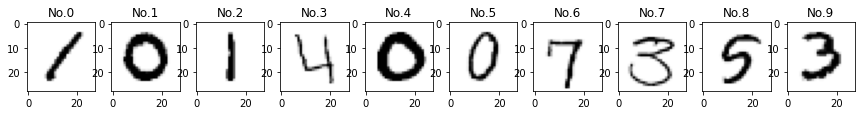

In [11]:
plt.figure(figsize=(30,30))
for i in range(10):
    plt.subplot(20, 20, i+1)
    plt.title("No." + str(i))
    plt.imshow(train_data.iloc[:,1:].iloc[i].values.reshape(28,28),cmap='Greys')

6. Check if GPU is available or not.

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

Okay "Type='cuda'" means GPU is available.

7.Let's send data to GPU and reset optimaizer and define loss calculation,loss backward .etc

In [13]:
list_process=[]

In [14]:
def train(model, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)  
        optimizer.zero_grad()  
        output = model(data) 
        loss = criterion(output, label)  
        loss.backward() 
        optimizer.step()  
        train_loss += loss.item() 
        #get argmax values in outputs
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()
    print('epoch for train: {}, accuracy: ({:.2f}%)'.format(epoch,correct*100 / len(train_loader.dataset)))
    list_process.append(correct*100 / len(train_loader.dataset))

8. Let's defing test. One thing different from "def train" is "torch.no_grad()".

In [15]:
def valid(model, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in valid_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += criterion(output, label).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
    print('epoch for test: {}, accuracy: ({:.2f}%)'.format(epoch,correct*100 / len(valid_loader.dataset)))

9. Define layers like Conv2d for CNN, max_pool2d for max pooing .etc

In [16]:
class cnn_layers(nn.Module):
    def __init__(self):
        super(cnn_layers,self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = cnn_layers()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss() 

/home/dev/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


10. Let's start 20-epoch deep learning.

In [17]:
print(model)
for epoch in tqdm(range(30)):
    train(model,epoch)

cnn_layers(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

epoch for train: 0, accuracy: (72.08%)
epoch for train: 1, accuracy: (89.22%)
epoch for train: 2, accuracy: (92.22%)
epoch for train: 3, accuracy: (93.90%)
epoch for train: 4, accuracy: (94.92%)
epoch for train: 5, accuracy: (95.67%)
epoch for train: 6, accuracy: (96.38%)
epoch for train: 7, accuracy: (96.72%)
epoch for train: 8, accuracy: (97.12%)
epoch for train: 9, accuracy: (97.19%)
epoch for train: 10, accuracy: (97.39%)
epoch for train: 11, accuracy: (97.60%)
epoch for train: 12, accuracy: (97.79%)
epoch for train: 13, accuracy: (97.95%)
epoch for train: 14, accuracy: (97.94%)
epoch for train: 15, accuracy: (98.14%)
epoch for train: 16, accuracy: (98.27%)
epoch for train: 17, accuracy: (98.25%)
epoch for train: 18, accuracy: (98.38%)
epoch for train: 19, accuracy: (98.39%)
epoch for train: 20, accuracy: (98.57%)
epoch for train: 21, accuracy: (98.58%)
epoch for train: 22, accuracy: (98.66%)
epoch for train: 23, accuracy: (98.75%)
epoch for train: 24, accuracy: (98.70%)
epoch for 

No handles with labels found to put in legend.


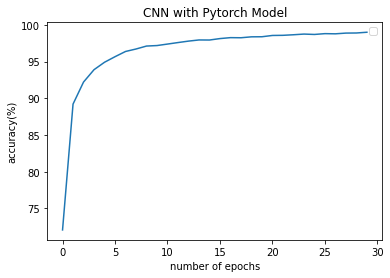

In [18]:
import matplotlib.pyplot as plt
plt.plot(list_process)
plt.xlabel("number of epochs")
plt.ylabel("accuracy(%)")
plt.title("CNN with Pytorch Model")
plt.legend()
plt.show()

In [19]:
for epoch in tqdm(range(3)):
    valid(model,epoch)

  0%|          | 0/3 [00:00<?, ?it/s]

epoch for test: 0, accuracy: (98.92%)
epoch for test: 1, accuracy: (98.92%)
epoch for test: 2, accuracy: (98.92%)


11. Let's check if this model's prediction is correct or not.

11-1. Make a dataloader for testing.

In [20]:
test_data = pd.read_csv('./digit-recognizer/test.csv')

In [21]:
x_test = test_data.values/255
x_test_torch = torch.from_numpy(x_test).type(torch.FloatTensor)
d_labels = np.zeros(x_test.shape)
d_labels = torch.from_numpy(d_labels)
#Think about dimentions of data. Without this "an shapes doesn't fit error", will occur.
x_test_torch = x_test_torch.view(-1, 1, 28, 28)
#Make a tensordataset and a testloader
testset = torch.utils.data.TensorDataset(x_test_torch, d_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = False)

11-2. Let's start prediction.

In [22]:
submit_list = [['ImageId', 'Label']]
with torch.no_grad():
    model.eval()
    image_id = 1
    for images,label in testloader:
        images,label = images.to(device), label.to(device)
        outputs = model(images)
        probs = torch.exp(outputs)
        top_p, top_class = probs.topk(1, dim = 1)
        for preds in top_class:
            submit_list.append([image_id,preds.item()])
            image_id += 1

11-3. Make a CSV file for submission

In [23]:
df = pd.DataFrame(submit_list)
df.columns = df.iloc[0]
df = df.drop(0, axis = 0)
df.to_csv('submit.csv', index = False)
print("submit.csv saved")

submit.csv saved


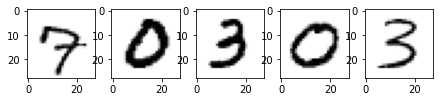

In [24]:
plt.figure(figsize=(30,30))
for i in range(5,10):
    plt.subplot(20, 20, i+1)
    plt.imshow(test_data.iloc[i].values.reshape(28,28),cmap='Greys')

In [25]:
df.iloc[5:10,[1]].T

,6,7,8,9,10
0,,,,,
Label,7,0,3,0,3


### Correct answers?!
### Thanks for reading my notebook :-) 